<a href="https://colab.research.google.com/github/Karthik482/test/blob/master/Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -c https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py

--2020-05-25 03:34:28--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2020-05-25 03:34:28 (53.9 MB/s) - ‘helper.py’ saved [2813/2813]



In [0]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

#note: transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 3 values means 3 channels, however for mnist there is only 1 channel, hence transforms.Normalize((0.5,), (0.5,))

In [4]:
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

valid_size = 0.2


# obtain training indices that will be used for validation
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [0]:
validloader = torch.utils.data.DataLoader(trainset, batch_size=64, 
    sampler=valid_sampler)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
    sampler=train_sampler)
testloader=torch.utils.data.DataLoader(testset,batch_size=64,shuffle=True)

Feed Forward

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [8]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

#note: You get error if you dont mention correct normalination for eg.. in transform 2nd chuck of code [(0.5,0.5)]. Mention currectly based on number of  channels. MNSIT has 1 channel

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the ps.topk method. This returns the  𝑘  highest values. Since we just want the most likely class, we can use ps.topk(1). This returns a tuple of the top- 𝑘  values and the top- 𝑘  indices. If the highest value is the fifth element, we'll get back 4 as the index.

FULLY CONNECTED NEURAL NETWORK  WITH BACKPROPAGATION AND DROPOUT 

In [10]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)


n_epochs = 15
steps = 0




valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for images, labels in trainloader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the loss
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in validloader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the loss
        loss = criterion(output, labels)
        # update running validation loss 
        valid_loss += loss.item()*images.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    

Epoch: 1 	Training Loss: 0.626294 	Validation Loss: 0.581975
Epoch: 2 	Training Loss: 0.492147 	Validation Loss: 0.271277
Epoch: 3 	Training Loss: 0.464776 	Validation Loss: 0.483115
Epoch: 4 	Training Loss: 0.442013 	Validation Loss: 0.321802
Epoch: 5 	Training Loss: 0.431432 	Validation Loss: 0.731581
Epoch: 6 	Training Loss: 0.417767 	Validation Loss: 0.452420
Epoch: 7 	Training Loss: 0.411509 	Validation Loss: 0.290142
Epoch: 8 	Training Loss: 0.401366 	Validation Loss: 0.335711
Epoch: 9 	Training Loss: 0.394462 	Validation Loss: 0.235356
Epoch: 10 	Training Loss: 0.386593 	Validation Loss: 0.447881
Epoch: 11 	Training Loss: 0.389023 	Validation Loss: 0.303325
Epoch: 12 	Training Loss: 0.381351 	Validation Loss: 0.211800
Epoch: 13 	Training Loss: 0.381476 	Validation Loss: 0.489653
Epoch: 14 	Training Loss: 0.369301 	Validation Loss: 0.189123
Epoch: 15 	Training Loss: 0.364923 	Validation Loss: 0.188679


Load the Model with the Lowest Validation Loss

In [35]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

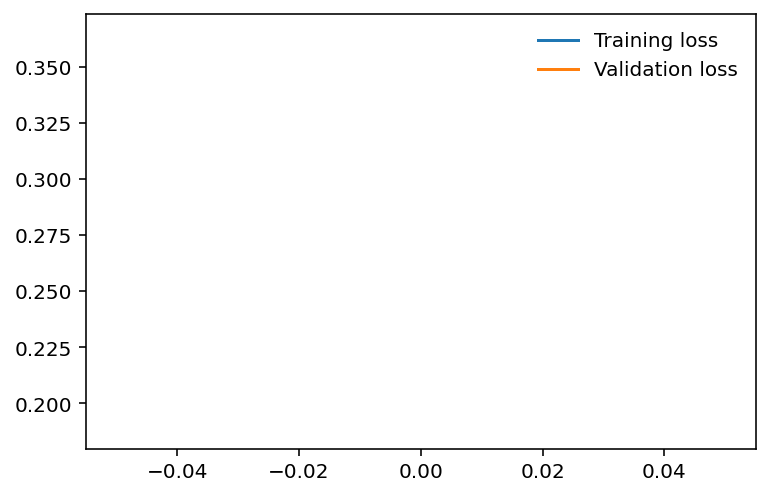

In [13]:
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend(frameon=False)


Test the Trained Network

In [60]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for images, labels in testloader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(images)
    # calculate the loss
    loss = criterion(output, labels)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(testloader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.196480

Test Accuracy of     0: 80% (803/1000)
Test Accuracy of     1: 96% (965/1000)
Test Accuracy of     2: 70% (706/1000)
Test Accuracy of     3: 88% (889/1000)
Test Accuracy of     4: 86% (867/1000)
Test Accuracy of     5: 93% (939/1000)
Test Accuracy of     6: 64% (649/1000)
Test Accuracy of     7: 92% (925/1000)
Test Accuracy of     8: 96% (966/1000)
Test Accuracy of     9: 96% (964/1000)

Test Accuracy (Overall): 86% (8673/10000)


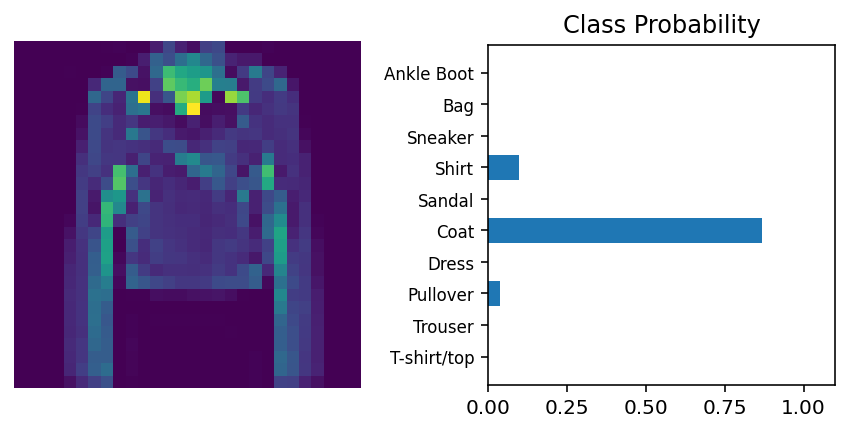

In [61]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')